In [57]:
print("welcome to Fine Tuning classical models")

welcome to Fine Tuning classical models


In [58]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [59]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [60]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [61]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [62]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})   

In [63]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [64]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [65]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [66]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # Note: A more pythonic version to implement this method
        # is the following, which is also used in the next chapter:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [67]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [68]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [69]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [70]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [71]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [72]:
import torch
from main import GPTModel

# Same config as during training
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 256,  # must match training
    "emb_dim": 768,
    "n_heads": 4,
    "n_layers": 1,
    "drop_rate": 0.1,
    "qkv_bias": False
}

# 1. Recreate model architecture
model = GPTModel(BASE_CONFIG)

# 2. Load weights
state_dict = torch.load("model.pth", map_location="cuda", weights_only=True)
model.load_state_dict(state_dict)

# 3. Set to eval mode if just generating
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  )
  (final_norm): LayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=Fa

In [73]:
import tiktoken
from main import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

# Alternatively:
# from llms_from_scratch.ch05 import (
#    generate_text_simple,
#    text_to_token_ids,
#    token_ids_to_text
# )


text_1 = "I want him"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

I want him the sunburnt.

I glanced after him, struck by his


In [74]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' at the donkey again. I may be pardoned the bull--that I found her so. For Jack, all


In [75]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  )
  (final_norm): LayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=Fa

In [76]:
for param in model.parameters():
    param.requires_grad = False

In [77]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [78]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [79]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [80]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) 

Outputs:
 tensor([[[0.1754, 0.8129],
         [0.3631, 0.0451],
         [0.3737, 0.5390],
         [1.4140, 0.7057]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [81]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[1.4140, 0.7057]])


In [82]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[1.4140, 0.7057]])


In [83]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 0


In [84]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 0


In [85]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 51.25%


In [87]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [88]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [89]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.877
Validation loss: 0.840
Test loss: 0.893


In [90]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [91]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [92]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.859, Val loss 0.795
Ep 1 (Step 000050): Train loss 0.308, Val loss 0.355
Ep 1 (Step 000100): Train loss 0.254, Val loss 0.494
Training accuracy: 85.00% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.461, Val loss 0.373
Ep 2 (Step 000200): Train loss 0.363, Val loss 0.347
Ep 2 (Step 000250): Train loss 0.282, Val loss 0.390
Training accuracy: 82.50% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.215, Val loss 0.322
Ep 3 (Step 000350): Train loss 0.156, Val loss 0.259
Training accuracy: 97.50% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.053, Val loss 0.285
Ep 4 (Step 000450): Train loss 0.104, Val loss 0.221
Ep 4 (Step 000500): Train loss 0.076, Val loss 0.271
Training accuracy: 100.00% | Validation accuracy: 82.50%
Ep 5 (Step 000550): Train loss 0.117, Val loss 0.333
Ep 5 (Step 000600): Train loss 0.053, Val loss 0.259
Training accuracy: 100.00% | Validation accuracy: 87.50%
Ep 6 (Step 000650): Train los

In [93]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

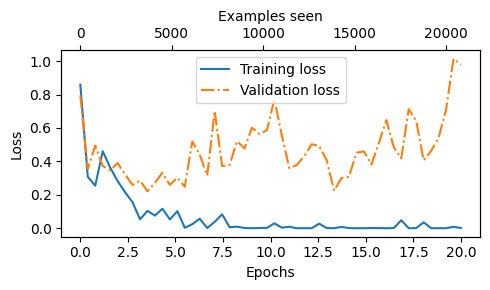

In [94]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

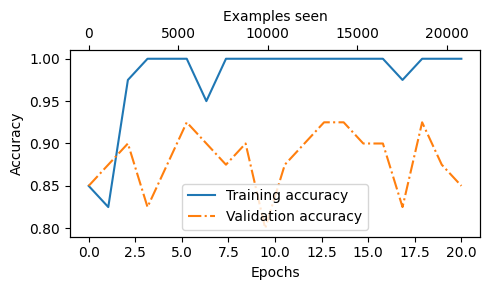

In [95]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [96]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 91.95%
Test accuracy: 94.67%


In [97]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )    
    # Alternatively, a more robust version is the following one, which handles the max_length=None case better
    # max_len = min(max_length,supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]
    
    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [98]:
text_1 = (
    "Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content."
    
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [101]:
text_2 = (
 "Congratulations! You have been selected to receive a $1,000 gift card, just click the link below to claim your reward immediately."

)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [102]:
torch.save(model.state_dict(), "review_classifier.pth")

In [103]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>